In [1]:
# Standard imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [20]:
# Constants:

# Contains 1.6M samples
PATH_DATA = "../input/sentiment140/training.1600000.processed.noemoticon.csv"

# 2B tweets, 27B tokens, 1.2M vocab, uncased,200-dimensional
PATH_EMB = "../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt"

# Dimensions of the embeddings
N_EMB = 200

# Number of samples to be taken
LIMIT = 1000000

# Fraction of samples to be used for training set
N_TRAIN = 0.9

# Size of each sequence to be embedded:
N_SEQ = 20 # Chosen based on the histogram of the lengths

## Data reading and pre-processing

In [3]:
# Function that returns the processed dataframe
def loadDF(n_samples):
    
    # Read
    df = pd.read_csv(
        PATH_DATA, 
        encoding = "latin", # No encoding results in decode error 
        header = None
    )
    
    # Drop columns which aren't needed
    df.drop(labels = [1,2,3,4], axis = "columns", inplace = True)
    df.columns = ["Label", "Text"]
    
    # Relabel 0 -> 0 and 4 -> 1 (0:Negative, 1:Positive)
    df.replace(to_replace = 4, value = 1, inplace = True)
    
    # Training on 1.6M samples takes a lot of time, we train on a smaller randomized subset of the data
    df = df.sample(n = n_samples, random_state = 42)
    
    return df

In [4]:
df = loadDF(LIMIT)
print("Class distribution:\n{}".format(df["Label"].value_counts()))

Class distribution:
0    500167
1    499833
Name: Label, dtype: int64


## Cleaning the data:

In [ ]:
# Check for null values
check = df.isnull().sum()
print(check)

In [8]:
import re
import nltk
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer

puncs = string.punctuation
sw = stopwords.words("english")
sb = SnowballStemmer(language = "english") # Better and faster than PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions (@username), all URLs.  (\S+ matches with everything that is not a whitespace)
    text = re.sub("@\S+|http\S+", "", text)
    # Remove punctuations (Redundant step, handled later in Keras tokenizer)
    text.translate(str.maketrans('', '', puncs))
    # Strip off accents (convert to ascii)
    text = unidecode(text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Stem, remove stop words and non-alphanumeric tokens
    cleaned_tokens = [sb.stem(t) for t in tokenized_text if t.isalnum() and t not in sw]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

In [9]:
def cleanDF(df):
    df["Text"] = df["Text"].apply(lambda x : preprocess(x))
    return df

In [10]:
# This takes a lot of time
## 4.656230688095093 for 10000 samples, scales linearly, thus ~12.5 mins for entire set
## 3.301717519760132 without stemming for 10000 samples
df = cleanDF(df)
display(df)

,Label,Text
541200,0,ahhh hope ok
750,0,cool tweet app razr 2
766711,0,know famili drama next time u hang kim n u guy...
285055,0,school email wo open geographi stuff revis
705995,0,upper airway problem
...,...,...
21340,0,bad time lap top broken good time found love p...
80620,0,yeah fun think movi
411912,0,ministri agricultur forest keep take catnip ma...
798815,0,sad news farrah fawcett pass away


## WordCloud visualization:

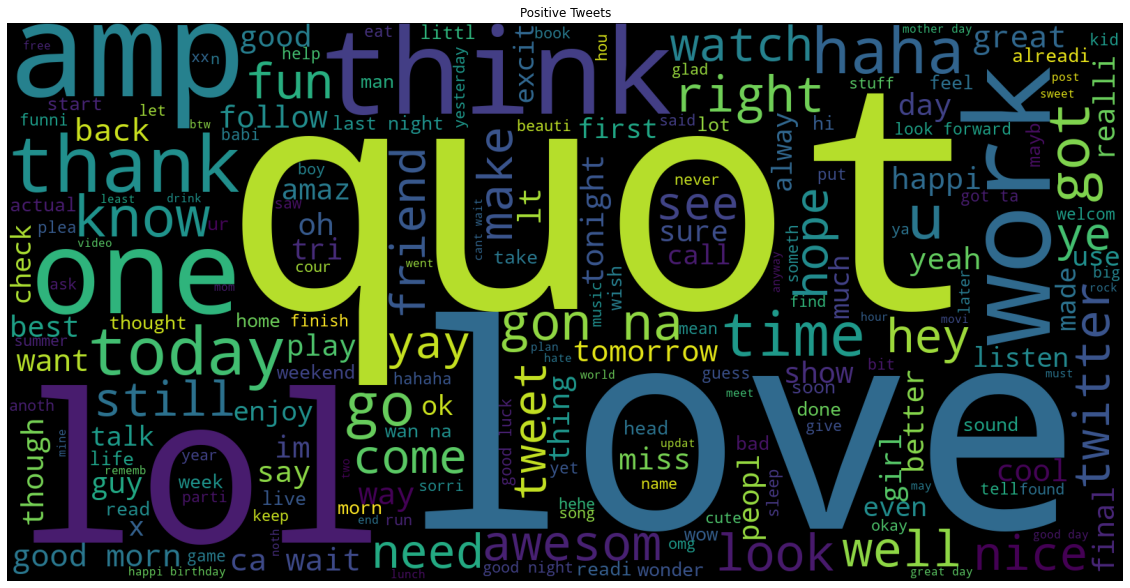

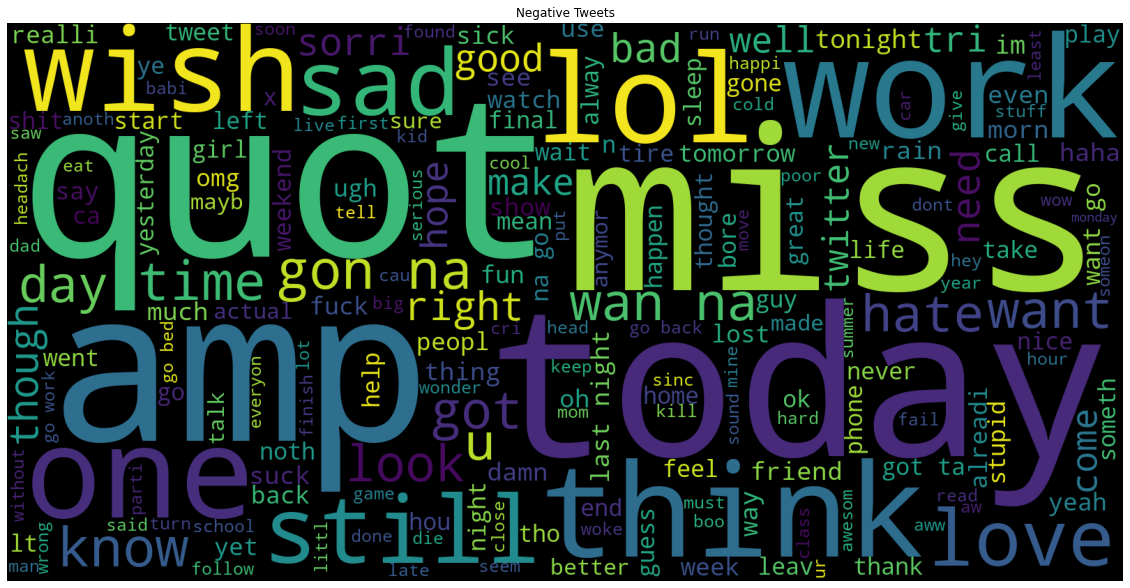

In [16]:
from wordcloud import WordCloud

df_pos = df.loc[df["Label"] == 1]
df_neg = df.loc[df["Label"] == 0]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["Text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["Text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()

## Analyze the length of the tweets:
This will help us select the `N_SEQ`

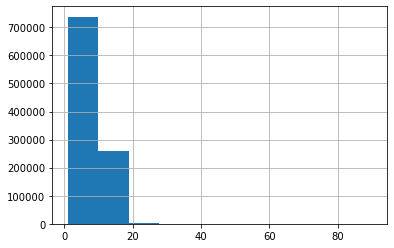

In [19]:
lengths = df["Text"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

Most values are less than 20, thus we keep `N_SEQ = 20`

## Preparation before model training

In [21]:
from sklearn.model_selection import train_test_split as tts

# Split into training and validation sets
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

In [22]:
from keras.preprocessing.text import Tokenizer

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(df_train["Text"])
    return tok

In [23]:
tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1 # This +1 is used later 
print(N_vocab)

158604


In [25]:
from keras.preprocessing.sequence import pad_sequences

def getXY(tok):
    x_train = pad_sequences(tok.texts_to_sequences(df_train["Text"]), maxlen = N_SEQ)
    x_val   = pad_sequences(tok.texts_to_sequences(df_val["Text"]), maxlen = N_SEQ)
    y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
    y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)
    return x_train, x_val, y_train, y_val

In [26]:
x_train, x_val, y_train, y_val = getXY(tok)

## Preparing the Embedding layer
Reference: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [27]:
# Maps each word in the embeddings vocabulary to it's embedded representation 
embeddings_index = {}
with open(PATH_EMB, "r", errors="ignore") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [28]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
embedding_matrix = np.zeros((N_vocab, N_EMB))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## The Model:

In [29]:
# Model constants:
LR = 0.001 # Default for Adam
N_BATCH = 256
N_EPOCHS = 5

In [30]:
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D

def buildModel():
    
    # The input as sequences:
    input_layer = Input(shape=(N_SEQ,))
    # Create the embedding layer
    embedding_layer = Embedding(
        N_vocab,
        N_EMB,
        weights = [embedding_matrix],
        input_length = N_SEQ,
        trainable = False # No need to train as our embeddings are already finetuned on Twitter data
    )
    # Create the embeddings
    embedded_sequences = embedding_layer(input_layer)
    
    # The core of the model:
    ## Learn spatial/postional features via 1D CNN
    x = Conv1D(filters = 128, kernel_size = 3, activation = "relu")(embedded_sequences)
    
    ## 2-layered BiLSTM architecture
    x = Bidirectional(LSTM(128, dropout = 0.2,recurrent_dropout = 0.2, return_sequences = True))(x)
    x = Bidirectional(LSTM(128, dropout = 0.2,recurrent_dropout = 0.2))(x) 
    
    # A rule of thumb is to have the number of hidden units be in-between the number of input units (200) and output classes (2)
    
    # Fully connected classifer (can be improved a lot):
    outputs = Dense(1, activation = "sigmoid")(x)
    
    model = Model(input_layer, outputs)
    return model

In [31]:
model = buildModel()

model.compile(
    optimizer = Adam(learning_rate = LR), 
    loss = "binary_crossentropy", # As binary classification
    metrics = ["accuracy"] # Balanced classes, thus good enough metric
)

callbacks_list = [
    ModelCheckpoint(filepath = "model_{epoch:02d}_{val_loss:.2f}.h5"),
]

print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 200)           31720800  
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 128)           76928     
_________________________________________________________________
bidirectional (Bidirectional (None, 18, 256)           263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 32,455,393
Trainable params: 734,593
Non-trainable params: 31,720,800
____________________________________

## Training:

In [32]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size = N_BATCH, 
    epochs = N_EPOCHS,
    validation_data = (x_val, y_val), 
    callbacks = callbacks_list
)

Epoch 1/5
3516/3516 [==============================] - 1030s 293ms/step - loss: 0.4863 - accuracy: 0.7627 - val_loss: 0.4679 - val_accuracy: 0.7743
Epoch 2/5
3516/3516 [==============================] - 1032s 293ms/step - loss: 0.4582 - accuracy: 0.7807 - val_loss: 0.4566 - val_accuracy: 0.7803
Epoch 3/5
3516/3516 [==============================] - 1050s 299ms/step - loss: 0.4460 - accuracy: 0.7880 - val_loss: 0.4537 - val_accuracy: 0.7835
Epoch 4/5
3516/3516 [==============================] - 1035s 294ms/step - loss: 0.4368 - accuracy: 0.7937 - val_loss: 0.4527 - val_accuracy: 0.7849
Epoch 5/5
3516/3516 [==============================] - 1012s 288ms/step - loss: 0.4291 - accuracy: 0.7978 - val_loss: 0.4541 - val_accuracy: 0.7845


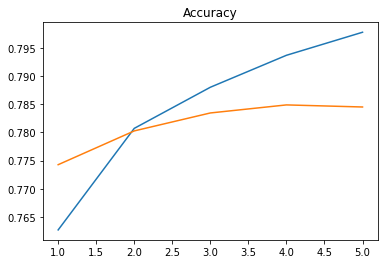

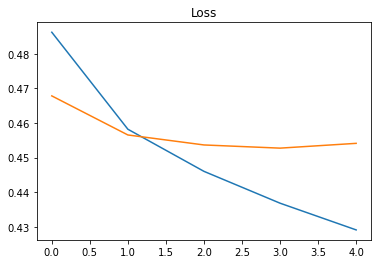

In [33]:
metrics = history.history
t_acc = metrics["accuracy"]
t_loss = metrics["loss"]
v_acc = metrics["val_accuracy"]
v_loss = metrics["val_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")

plt.show()